In [ ]:
import functools
import functorch as ft
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.autograd.forward_ad as fwAD
import torchvision
import tqdm

from statistics import mean 
from torch import nn
from torch.utils.data import DataLoader

# Gradients without Backpropagation

## 1. Description of the method

### Introduction
The paper introduces a new method to compute the gradient of an objective function for optimization that is based on forward mode instead of reverse mode (backpropagation).So, the key idea to evaluate the gradient in a single forward run of the function eliminating the need of backpropagation. 

### Proposed method
The method proposed by the authors of the paper consists of the following steps: 


1.   Sample a random perturbation vector  $v\sim p(v)$, which has the same size with $f’s$ argument $\theta$. In particular $p(v)$ must have two properties:  the components must be independent from each other, the components must have zero mean and unit variance. 
2.   Simultaneously compute $f(\theta)$ and $\nabla f(\theta) \cdot v$ in a single forward run without having to compute $\nabla f(\theta)$ at all in the process. 
3. Now the authors define the forward gradient as $g (\theta) = (\nabla f(\theta) \cdot v) \cdot v$. They prove that the forward gradient $g(\theta)$ is an unbiased estimator of the gradient $\nabla f(\theta)$. So, the last step is to compute this value, $g (\theta) $, and use it to update the parameters. 


The final algorithm is the following: 
![picture](https://github.com/martinasgnaolin/Pictures/blob/main/FGD.png?raw=true)























### Our implementation
First of all given parameters $params$, we generate the sample perturbation vector $v$ as $v = torch.randn\_like(params)$. This implementatio respects the properties described above because, from documentation:
" $torch.randn\_like$" returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean $0$ and variance $1$" [1.1].

In the following step we need to implement the computation of $f$ and $d$ simultaneously in the forward pass. To do this we use this documentation [1.2]. In particular, we follow two methods of the documentation linked above: one for the test functions and one for the modules. However, both are based on the implementation of dual numbers that allow to compute in forward automatic differentiation the output and its derivative in a single run. In the first example we use the method described in the first paragraph of the documentation [1.2]. Indeed, in Pytorch it's possible to use forward-mode AD to compute a directional derivative by performing the forward pass, except we first associate our input with another tensor ($make\_dual$) representing the direction of the directional derivative (or equivalently, the $v$ in a Jacobian-vector product). When an input, which we call "dual_input", is associated with a "direction" tensor, which we call "v", the results, obtained by applying $fwAD.unpack\_dual(dual\_output)$, are saved in $f$ and $d$. With $d$, we can compute finally the forward gradient. 
Instead in the second example, multi-layer Neural Network, we decide to use $functorch.jvp$ that is more suitable for the modules. Indeed, $train\_loss, d = ft.jvp(func\_params\_only, (params,), (v,))$ allows to compute Jacobian-vector products with respect to the model parameters and as a consequence we need to reformulate the model as a function that accepts both the model parameters and inputs to the module.
In the last step, we simply compute the forward gradient in this way: 
$g = d \cdot v $ and then we use this value to update the parameters: $params -= lr \cdot g$. 

The next sections will show in more detail the implementations described earlier. 



 

## 2. Example 1: Optimization Trajectories of Test Functions




First, we followed one of the experiments held by the authors of the paper. From the paper: "First we look at test functions for optimization, and compare
the behavior of forward gradient and backpropagation in the $\mathbb{R}^2$ space where we can plot and follow optimization trajectories". The functions used for this purpose are:


*   the Beale function: $f(x, y)=(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2$
*   and the Rosenbrock function: $f(x,y)=(a-x)^2+b(y-x^2)^2$, where $a=1, b=100$



### Beale Function

In [ ]:
# This is the direct implementation of the Beale Function defined above
def beale(params):
  x = params[0]
  y = params[1]
  return (
      (torch.tensor([1.5]) - x + x * y) ** 2 + 
      (torch.tensor([2.25]) - x + x * y ** 2) ** 2 + 
      (torch.tensor([2.625]) - x + x * y ** 3) ** 2
  )

In [ ]:
# Initialization of parameters
epochs = 1000 
lr = 0.01 # Learning rate

# Lists to store results
hist_beale_fgd = [] # List used to store the results of the optimization process at each epoch
time_beale_fgd = [] # List used to store the time at each epoch
hist_beale_sgd = [] # List used to store the results of the optimization process at each epoch
time_beale_sgd = [] # List used to store the time at each epoch

#### Forward Gradient Implementation

In [ ]:
params = torch.rand(2) # Initialization of the parameters that we aim to optimize
t_0 = time.time() # Initial time

for epoch in range(epochs):
  v = torch.randn_like(params) # Sample perturbation vector
  
  # Computation of both output and derivative
  with fwAD.dual_level():
    dual_input = fwAD.make_dual(params, v)
    dual_output = beale(dual_input)
    f, d = fwAD.unpack_dual(dual_output)

  g = d * v # Forward gradient
  params -= lr * g # Parameter update

  # Updating the lists 
  hist_beale_fgd.append(f.item()) 
  t = time.time()
  time_beale_fgd.append(t - t_0)

#### Backpropagation




In [ ]:
params = torch.rand(2) # Initialization of the parameters that we aim to optimize
t_0 = time.time() # Initial time

opt = torch.optim.SGD([params], lr=lr) # As optimizer we choose SGD and pass to it the parameters and the learning rate

for epoch in range(epochs):  
  params.requires_grad_(True)
  opt.zero_grad() # We zero the gradients
  f = beale(params) # Computation of the output
  f.backward() # Compute the gradient
  opt.step() # Perform optimization step automatically over the parameters

  # Updating the lists
  hist_beale_sgd.append(f.item()) 
  t = time.time()
  time_beale_sgd.append(t - t_0)

#### Results plotted

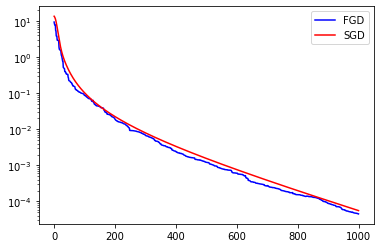

In [ ]:
# Results Beale wrt Epochs
x = np.array(np.arange(0, epochs, 1))
y_f = hist_beale_fgd
y_s = hist_beale_sgd

fig, ax = plt.subplots()
ax.plot(x, y_f, 'b')
ax.plot(x, y_s, 'r')
ax.set_yscale('log')
ax.legend(['FGD', 'SGD'])

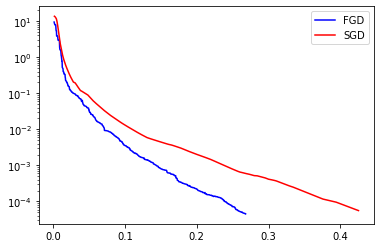

In [ ]:
# Results Beale wrt Time
x_f = time_beale_fgd
x_s = time_beale_sgd
y_f = hist_beale_fgd
y_s = hist_beale_sgd

fig, ax = plt.subplots()
ax.plot(x_f, y_f, 'b')
ax.plot(x_s, y_s, 'r')
ax.set_yscale('log')
ax.legend(['FGD', 'SGD'])

### Rosenbrock Function

In [ ]:
# This is the direct implementation of the Rosenbrock Function defined above
def rosenbrock(params):
  x = params[0]
  y = params[1]
  return (torch.tensor([1]) - x) ** 2 + 100 * (y - x ** 2) ** 2

In [ ]:
# Initialization of parameters
epochs = 25000 
lr = 0.0005 # Learning rate

# Lists to store results
hist_rosenbrock_fgd = [] # List used to store the results of the optimization process at each epoch
time_rosenbrock_fgd = [] # List used to store the time at each epoch
hist_rosenbrock_sgd = [] # List used to store the results of the optimization process at each epoch
time_rosenbrock_sgd = [] # List used to store the time at each epoch

#### Forward Gradient Implementation

In [ ]:
params = torch.rand(2) # Initialization of the parameters that we aim to optimize
t_0 = time.time() # Initial time

for epoch in range(epochs):
  v = torch.randn_like(params) # Sample perturbation vector
  
  # Computation of both output and derivative
  with fwAD.dual_level():
    dual_input = fwAD.make_dual(params, v)
    dual_output = rosenbrock(dual_input)
    f, d = fwAD.unpack_dual(dual_output)

  g = d * v # Forward gradient
  params -= lr * g # Parameter update

  # Updating the lists 
  hist_rosenbrock_fgd.append(f.item()) 
  t = time.time()
  time_rosenbrock_fgd.append(t - t_0)

#### Backpropagation


In [ ]:
params = torch.rand(2) # Initialization of the parameters that we aim to optimize
t_0 = time.time() # Initial time

opt = torch.optim.SGD([params], lr=lr) # As optimizer we choose SGD and pass to it the parameters and the learning rate

for epoch in range(epochs):  
  params.requires_grad_(True)
  opt.zero_grad() # We zero the gradients
  f = rosenbrock(params) # Computation of the output
  f.backward() # Compute the gradient
  opt.step() # Perform optimization step automatically over the parameters

  # Updating the lists
  hist_rosenbrock_sgd.append(f.item()) 
  t = time.time()
  time_rosenbrock_sgd.append(t - t_0)

#### Results plotted

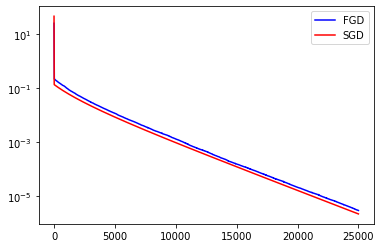

In [ ]:
# Results Rosenbrock wrt Epochs
x = np.array(np.arange(0, epochs, 1))
y_f = hist_rosenbrock_fgd
y_s = hist_rosenbrock_sgd

fig, ax = plt.subplots()
ax.plot(x, y_f, 'b')
ax.plot(x, y_s, 'r')
ax.set_yscale('log')
ax.legend(['FGD', 'SGD'])

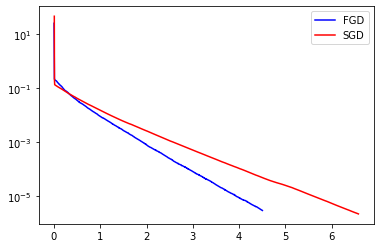

In [ ]:
# Results Rosenbrock wrt Time
x_f = time_rosenbrock_fgd
x_s = time_rosenbrock_sgd
y_f = hist_rosenbrock_fgd
y_s = hist_rosenbrock_sgd

fig, ax = plt.subplots()
ax.plot(x_f, y_f, 'b')
ax.plot(x_s, y_s, 'r')
ax.set_yscale('log')
ax.legend(['FGD', 'SGD'])

### Results

For this first experiment, we used the same values of the authors of the paper for the following parameters: number of iterations (1,000 for Beale function, 25,000 for Rosenbrock function), learning rate (0.01 for Beale function, 0.0005 for Rosenbrock function). The results that we obtain are in line with theirs. In general, we notice that the loss behaves similarily both in forward gradient and backpropagation with respect to the number of iterations. However, forward gradient converges to the solution slightly faster per iteration. 

**Beale function:**

These are the results of the loss obtained by the authors with respect to the number of epochs and the time:

![picture](https://github.com/martinasgnaolin/Pictures/blob/main/Beale.png?raw=true)

This is the loss that we obtained with respect to the number of iterations:

![picture](https://github.com/martinasgnaolin/Pictures/blob/main/Beale_nostra_loss_.png?raw=true)

Instead, here is the loss with respect to the time:

![picture](https://github.com/martinasgnaolin/Pictures/blob/main/Beale_nostra_time_.png?raw=true)

**Rosenbrock function:**

Here are the results of the loss obtained by the authors with respect to the number of epochs and the time:

![picture](https://github.com/martinasgnaolin/Pictures/blob/main/Rosenbrock.png?raw=true)

This is the loss that we obtained with respect to the number of iterations:

![picture](https://github.com/martinasgnaolin/Pictures/blob/main/Rosenbrock_nostra_loss_.png?raw=true)

Here is the loss with respect to the time:

![picture](https://github.com/martinasgnaolin/Pictures/blob/main/Rosenbrock_nostra_time_.png?raw=true)

Of course, our results in time are slightly worse than those of the authors due to our limited computational resources.

## 3. Example 2: Multi-Layer Neural Network

Also for our second experiment, we followed one of those held by the authors of the paper. In particular, we tested the method on a multi-layer neural
network for MNIST classification. From the paper, the architecture should have "three fully-connected layers of size 1024, 1024, 10, with ReLU activation after the first two layers". 

### Model

In [ ]:
# This is the implementation of the architecture defined above
#The forward method includes the computation of the loss. This can be useful during the training
class Model(nn.Module):
    
    def __init__(self):
      super(Model, self).__init__()
      self.flatten = nn.Flatten()
      self.fc1 = nn.Linear(28*28, 1024)
      self.fc2 = nn.Linear(1024, 1024)
      self.fc3 = nn.Linear(1024, 10)

    def forward(self, x, y):
      x = self.flatten(x)
      x = nn.functional.relu(self.fc1(x))
      x = nn.functional.relu(self.fc2(x))
      x = self.fc3(x)
      x = nn.functional.softmax(x, dim=-1)
      loss = nn.functional.cross_entropy(x, y)
      return loss

### Dataset

In [ ]:
# Download the dataset applying the transformation

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor() 
])

train_data = torchvision.datasets.MNIST('/content/data', train=True, download=True, transform = transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [ ]:
# Dataloader

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64)

In [ ]:
# Now let's define the test data and test loader

test_data = torchvision.datasets.MNIST('/content/data', train=False, download=True, transform = transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Forward Gradient Implementation

In [ ]:
# Instantiation of the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Model()

# Initializations of the parameters
epochs = 100
lr = 2e-4

# Lists to keep track of the values of the loss
history_fgd_train = []
history_fgd_valid= []
time_fgd = []

In [ ]:
# We disable gradient computation to reduce memory consumption since we are not 
# going to use Tensor.backward() (from documentation [3.1])
with torch.no_grad():
  model.to(device)
  model.float()
  model.train() 

  # f, params, buffers = ft.make_functional_with_buffers(model) #returns a functional version of the model so that can be invoked like a function
  f, params = ft.make_functional(model) #returns a functional version of the model so that can be invoked like a function
  t_0 = time.time() # Initial time
  
  for epoch in range(epochs):
    batch_train_loss = []
    batch_valid_loss = []
    for xb, yb in tqdm.tqdm(train_loader):
      xb, yb = xb.to(device), yb.to(device) # xb are the images, yb the labels

      v = tuple([torch.rand_like(p) for p in model.parameters()]) #sample perturbation vector

      #Because jvp requires every input to be associated with a tangent, we need to
      #create a new function that, when given the parameters, produces the output (from documentation [1.2])
      def func_params_only(params): 
        return f(params, xb, yb)
      
      # Computation of both output and derivative
      train_loss, d = ft.jvp(func_params_only, (params,), (v,))
      batch_train_loss.append(train_loss.item())

      for j, p in enumerate(params): 
        g = d * v[j] #Forward gradient
        p -= lr * g #Parameter update
    
    # Compute the validation loss
    for xb, yb in test_loader:
      xb, yb = xb.to(device), yb.to(device)
      valid_loss = func_params_only(params)
      batch_valid_loss.append(valid_loss.item())
  
    # Print the results and update the lists
    t = time.time()
    time_fgd.append(t - t_0)
    print(f"Epoch [{epoch+1}], Loss: {mean(batch_train_loss):.4f}, Valid loss: {mean(batch_valid_loss):.4f}")  
    history_fgd_train.append(mean(batch_train_loss))    
    history_fgd_valid.append(mean(batch_valid_loss))

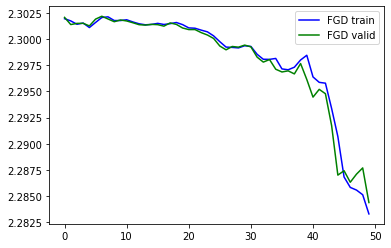

In [ ]:
# Results forward wrt Epochs
x = np.array(np.arange(0, epochs, 1))
y_t = history_fgd_train
y_v = history_fgd_valid

fig, ax = plt.subplots()
ax.plot(x, y_t, 'b')
ax.plot(x, y_v, 'g')
ax.legend(['FGD train', 'FGD valid'])

### Backpropagation

In [ ]:
# Instantiation of the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Model().to(device)

# Initializations of the parameters
epochs = 100
lr = 2e-4
opt = torch.optim.SGD(model.parameters(), lr=lr) # As optimizer we choose SGD and pass to it the parameters and the learning rate

# Lists to keep track of the values of the loss
history_sgd_train = []
history_sgd_valid= []
time_sgd = []

In [ ]:
t_0 = time.time() # Initial time

for epoch in range(epochs):
  model.train()
  batch_train_loss = []
  batch_valid_loss = []
  for xb, yb in tqdm.tqdm(train_loader):
     xb,yb = xb.to(device), yb.to(device) # xb are the images, yb the labels

     opt.zero_grad() # We zero the gradients 
     train_loss = model(xb,yb) # Computation of the loss
     batch_train_loss.append(train_loss.item())
     train_loss.backward() # Backpropagation
     opt.step() # Updating the parameters

  # Compute the valid loss
  for xb, yb in test_loader:
     xb,yb = xb.to(device), yb.to(device)
     valid_loss = model(xb, yb)
     batch_valid_loss.append(valid_loss.item())
  
  # Print and update the lists
  t = time.time()
  time_sgd.append(t - t_0)
  print(f"Epoch [{epoch+1}], Loss: {mean(batch_train_loss):.4f}, Valid loss: {mean(batch_valid_loss):.4f}")
  history_sgd_train.append(mean(batch_train_loss))  
  history_sgd_valid.append(mean(batch_valid_loss))

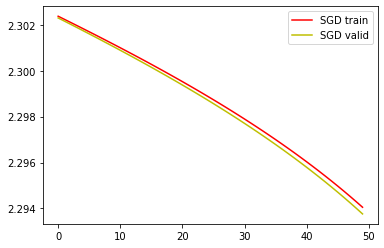

In [ ]:
# Results backpropagation wrt Epochs
x = np.array(np.arange(0, epochs, 1))
y_t = history_sgd_train
y_v = history_sgd_valid

fig, ax = plt.subplots()
ax.plot(x, y_t, 'r')
ax.plot(x, y_v, 'y')
ax.legend(['SGD train', 'SGD valid'])

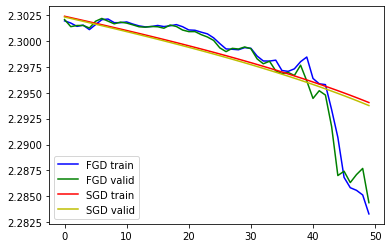

In [ ]:
# Plot the results for both FGD and SGD wrt number of epochs
x = np.array(np.arange(0, epochs, 1))
yft = history_fgd_train
yfv = history_fgd_valid
yst = history_sgd_train
ysv = history_sgd_valid

fig, ax = plt.subplots()
ax.plot(x, yft, 'b')
ax.plot(x, yfv, 'g')
ax.plot(x, yst, 'r')
ax.plot(x, ysv, 'y')
ax.legend(['FGD train', 'FGD valid', 'SGD train', 'SGD valid'])

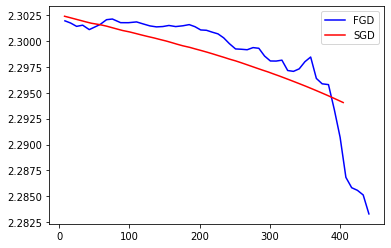

In [ ]:
# Plot the results wrt time in FGD and SGD
x_f = time_fgd
x_s = time_sgd
y_f = history_fgd_train
y_s = history_sgd_train

fig, ax = plt.subplots()
ax.plot(x_f, y_f, 'b')
ax.plot(x_s, y_s, 'r')
ax.legend(['FGD', 'SGD'])

### Results

Also for this second experiment, we tired to set as parameters the same ones used by the authors of the paper, in order to better compare our results with theirs.
In particular we used:


*   Number of epochs: we couldn't run our training for 20,000 epochs (due to our limited computational resources), so we only performed xxx iterations
*   Learning rate: $2 \times 10^{-4}$

DA RIVEDERE QUANDO ABBIAMO I RISULTATI
In general, we notice that the results in terms of loss with respect to the number of iterations is better in the Forward Gradient Descent, even though the runtime is slightly worse compared to that of the Stochastic Gradient Descent.However, we can say from the different trainings we performed that the times of Stochastic Gradient Descent and Forward gradient are , at the end, comparable.  

Here is a graphic representation of the results presented in the paper:
![picture](...)

## Summary of the main Results

Our project implements the paper "Gradients without Backpropagation". The authors show how to do gradient descent only using a single forward pass instead of backpropagating through the network. Our approach is implemented in Pytorch. Taking the two reference use cases into consideration, we can say that the performance of forward gradient is better than backpropagation in terms of loss. For time, on the other hand, we note that in the first example the forward also performs better. However we notice a deterioration in time in the second example but despite this the times of both remain comparable. The results obtained in the first case coincide perfectly with those of the authors of the paper, while in the second we noticed only a slight difference in the times as mentioned before. However, we have to consider the difference in the resources used by us which are not comparable to those used by the authors. Indeed we use the free version of Google Colab and it does not provide much computational power; this highly limited how many samples we were able to use and for how long we were able to train/test the models. Indeed, after some time of using the free GPU, the account that uses it would be temporarily suspended for exceeding the GPU availability time (circa four hours). For this reason, we were unable  to train as long as needed to reach the same results of paper [4]but we are pretty sure that we would get even better results if additional training were performed. 
So, we can conclude that from the paper [4]: "The runtime results we obtained with our forward AD prototype in PyTorch are encouraging and we are cautiously optimistic enabling the training of more complex architectures with a given compute budget". For this reason, this idea can be used to create forward gradient versions of any algorithm that uses gradients. However, beware of the noise that the forward gradient introduces, which may not be useful in some algorithms [5]. 








## References

[1.1] https://pytorch.org/docs/stable/generated/torch.randn_like.html

[1.2] https://pytorch.org/tutorials/intermediate/forward_ad_usage.html

[3.1] https://pytorch.org/docs/stable/generated/torch.no_grad.html

[4] Atılım Gunes Baydin, Barak A. Pearlmutter, Don Syme, Frank Wood, Philip Torr, 2022. Gradients without Backpropagation (https://arxiv.org/pdf/2202.08587.pdf)

[5] Dr. Robert Kübler, 2022. Papers Simplified: Gradients without Backpropagation (https://towardsdatascience.com/papers-simplified-gradients-without-backpropagation-96e8533943fc)